## CRNN model

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME') + "/aiffel/ocr"

TRAIN_DATA_PATH = HOME_DIR + "/data/MJ/MJ_train"
VALID_DATA_PATH = HOME_DIR + "/data/MJ/MJ_valid"
TEST_DATA_PATH = HOME_DIR + "/data/MJ/MJ_test"

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [4]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        # load data
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)

            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)

            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs


In [5]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label


In [6]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [7]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model


In [8]:
# 데이터셋과 모델을 준비합니다
label_converter = LabelConverter(TARGET_CHARACTERS)
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.05, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = ModelCheckpoint(checkpoint_path, 
                      monitor='val_loss', 
                      verbose=1, 
                      save_best_only=True, 
                      save_weights_only=True)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp]
)

Epoch 1/20
565/565 [==============================] - 98s 151ms/step - loss: 26.0621 - val_loss: 26.6817

Epoch 00001: val_loss improved from inf to 26.68172, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 84s 148ms/step - loss: 22.7307 - val_loss: 22.3760

Epoch 00002: val_loss improved from 26.68172 to 22.37598, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 84s 148ms/step - loss: 15.5243 - val_loss: 12.8807

Epoch 00003: val_loss improved from 22.37598 to 12.88068, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 84s 148ms/step - loss: 9.9312 - val_loss: 8.8345

Epoch 00004: val_loss improved from 12.88068 to 8.83453, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 84s 148ms/step - loss: 7.5452 - val_loss: 7.5709

Epoch 00005: val_los

In [10]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'
model.load_weights(checkpoint_path)

# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


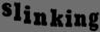

Result: 	 ALEPPO99999999999999999


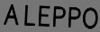

Result: 	 FWANDA999999999999999999


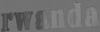

Result: 	 NATHANS99999999999999999


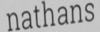

Result: 	 HALLE999999999999999999


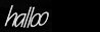

Result: 	 HURLS9999999999999999999


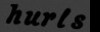

Result: 	 DOWNSIZE9999999999999999


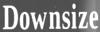

Result: 	 ROBOTIC99999999999999999


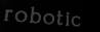

Result: 	 SLOPPY99999999999999999


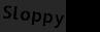

Result: 	 SHERMITE9999999999999999


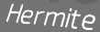

In [11]:
from IPython.display import display

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

## Keras OCR

In [12]:
import os
import cv2

HOME_DIR = os.getenv('HOME') + '/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

## detection

In [13]:
from keras_ocr.detection import Detector

detector = Detector()

def detect_text(image_path):    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    boxes = detector.detect([image])[0]
    cropped_images = []
    
    for box in boxes:
        top_left = int(box[0][1]), int(box[0][0])
        bottom_right = int(box[2][1]), int(box[2][0])

        cropped_image = image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1],:]
        cropped_images.append(cropped_image)
    
    return cropped_images

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


### recognition

In [14]:
from keras_ocr.recognition import Recognizer

recognizer = Recognizer()

def recognize_image(image):
    return recognizer.recognize(image)

Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


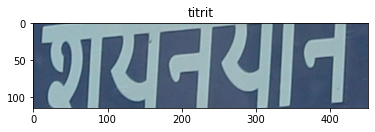

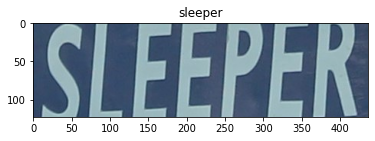

In [15]:
import matplotlib.pyplot as plt

for image in detect_text(SAMPLE_IMG_PATH):
    plt.imshow(image)
    plt.title(recognize_image(image))
    plt.show()

## 비교

- Keras OCR의 기본적으로 높은 성능을 보인다.
- RCNN의 경우 뒤에 9로 채워지는 것 외에도 문자 인식 성능 자체가 좋지 않았다.

RCNN: SLINKING9999999999999999
Keras OCR: slinking


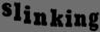

RCNN: ALEPPO99999999999999999
Keras OCR: aleppo


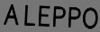

RCNN: FWANDA999999999999999999
Keras OCR: rwanda


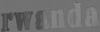

RCNN: NATHANS99999999999999999
Keras OCR: nathans


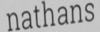

RCNN: HALLE999999999999999999
Keras OCR: hallo


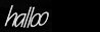

RCNN: HURLS9999999999999999999
Keras OCR: hurls


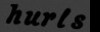

RCNN: DOWNSIZE9999999999999999
Keras OCR: downsize


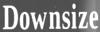

RCNN: ROBOTIC99999999999999999
Keras OCR: robotic


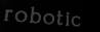

RCNN: SLOPPY99999999999999999
Keras OCR: sloppy


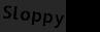

RCNN: SHERMITE9999999999999999
Keras OCR: hermite


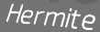

In [24]:
for i in range(10):
    image = test_set[i][0]["input_image"][0:1,:,:,:]

    rcnn_pred = model_pred.predict(image)
    rcnn_result = decode_predict_ctc(rcnn_pred, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    
    keras_ocr_result = recognize_image(image[0].transpose(1,0,2).astype(np.uint8))
    
    print(f"RCNN: {rcnn_result}")
    print(f"Keras OCR: {keras_ocr_result}")
    
    display(Image.fromarray(image[0].transpose(1,0,2).astype(np.uint8)))


RCNN: SIREN9999999999999999999
Keras OCR: siren


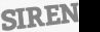

RCNN: PATHETILC999999999999999
Keras OCR: pathetlc


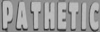

RCNN: FOPE99999999999999999999
Keras OCR: topee


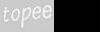

RCNN: BREASTS99999999999999999
Keras OCR: breasts


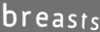

RCNN: RECONQUERS99999999999999
Keras OCR: reconquers


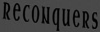

RCNN: PROSPECTUSES999999999999
Keras OCR: prospectuses


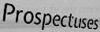

RCNN: DECOLETAGES9999999999999
Keras OCR: decolltages


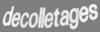

RCNN: BEHOOVE9999999999999999
Keras OCR: behoove


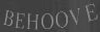

RCNN: UET999999999999999999999
Keras OCR: writ


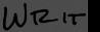

RCNN: ATMAN9999999999999999999
Keras OCR: atman


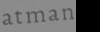

In [20]:
for i in range(100,110):
    image = test_set[i][0]["input_image"][0:1,:,:,:]

    rcnn_pred = model_pred.predict(image)
    rcnn_result = decode_predict_ctc(rcnn_pred, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    
    keras_ocr_result = recognize_image(image[0].transpose(1,0,2).astype(np.uint8))
    
    print(f"RCNN: {rcnn_result}")
    print(f"Keras OCR: {keras_ocr_result}")
    
    display(Image.fromarray(image[0].transpose(1,0,2).astype(np.uint8)))
